In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense, Activation
import datetime

### Load Dataset

In [2]:
data = pd.read_csv('005930.KS.csv')
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-05-29,46220.0,46400.0,45380.0,45620.0,39517.730469,8739550
1,2017-05-30,45520.0,45660.0,44480.0,44640.0,38668.828125,12433600
2,2017-05-31,44580.0,45020.0,44400.0,44700.0,38720.804688,18669100
3,2017-06-01,44860.0,44900.0,44400.0,44680.0,38703.468750,9753500
4,2017-06-02,45060.0,45960.0,45000.0,45960.0,39812.257813,12488750


### Compute Mid Price

In [3]:
high_prices = data['High'].values
low_prices = data['Low'].values
mid_prices = (high_prices + low_prices)/2

### Create Windows

In [4]:
seq_len = 50 # 윈도우 사이즈 최근 50일보고 한개를 예측한다. 51개씩저장해야한다.
sequence_length = seq_len + 1 # 51개 저장.

result = []
for index in range(len(mid_prices)-sequence_length):
    result.append(mid_prices[index:index + sequence_length])

### Normalize Data

In [5]:
normalized_data = []
for window in result:
    normalized_window = [((float(p)/float(window[0]))-1)for p in window]
    normalized_data.append(normalized_window)
    
result = np.array(normalized_data)

# split train and test data
row = int(round(result.shape[0]*0.9)) # 90퍼센트 트레이닝셋.
train = result[:row,:]
np.random.shuffle(train) # 트레이닝셋 순서 랜덤으로 셔플

x_train = train[:, :-1]
x_train = np.reshape(x_train,(x_train.shape[0],x_train.shape[1],1))
y_train = train[:, -1]

x_test = result[row:, :-1]
x_test = np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))
y_test = result[row:, -1]

x_train.shape, x_test.shape 

((1058, 50, 1), (117, 50, 1))

### Build a Model

In [6]:
m = Sequential()
m.add(LSTM(50,return_sequences=True,input_shape=(50,1)))
m.add(LSTM(64,return_sequences=False))
m.add(Dense(1,activation='linear'))
m.compile(loss='mse',optimizer='rmsprop')
m.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50, 50)            10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                29440     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 39,905
Trainable params: 39,905
Non-trainable params: 0
_________________________________________________________________


### Training

In [7]:
m.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size=10, epochs=20)

Epoch 1/20
106/106 [==============================] - 5s 27ms/step - loss: 0.0020 - val_loss: 4.3819e-04
Epoch 2/20
106/106 [==============================] - 2s 22ms/step - loss: 9.8563e-04 - val_loss: 6.0325e-04
Epoch 3/20
106/106 [==============================] - 2s 22ms/step - loss: 6.7368e-04 - val_loss: 2.1447e-04
Epoch 4/20
106/106 [==============================] - 2s 23ms/step - loss: 5.7348e-04 - val_loss: 3.5657e-04
Epoch 5/20
106/106 [==============================] - 3s 24ms/step - loss: 4.5772e-04 - val_loss: 2.4358e-04
Epoch 6/20
106/106 [==============================] - 3s 24ms/step - loss: 4.0500e-04 - val_loss: 1.5265e-04
Epoch 7/20
106/106 [==============================] - 2s 23ms/step - loss: 3.6322e-04 - val_loss: 1.2056e-04
Epoch 8/20
106/106 [==============================] - 2s 23ms/step - loss: 2.9320e-04 - val_loss: 2.7162e-04
Epoch 9/20
106/106 [==============================] - 2s 23ms/step - loss: 3.1165e-04 - val_loss: 2.7973e-04
Epoch 10/20
106/106 [==

### Prediction

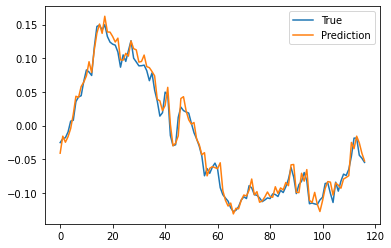

In [8]:
pred = m.predict(x_test)
fig = plt.figure(facecolor='white')
ax = fig.add_subplot(111)
ax.plot(y_test, label='True')
ax.plot(pred, label='Prediction')
ax.legend()
plt.show()
# 파랑색 - 실제데이터
# 주황색 - 예측데이터